According to Murphy we can write a semi-parametric GP as 
$$f(x) = g(x) + h(x)$$
where $$g(x|\theta)$$ is some parametric function and 
$$h(x) \sim GP(,)$$
us a Gaussian process on the residuals

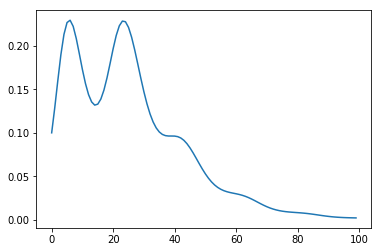

In [3]:
import numpy as np
import pylab as pl
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

seasonality = 20

def seasonal_forcing(t):
    return (1+np.cos(t*2*np.pi/seasonality))


def sir_step(S0,I0,R0,num_steps):  
    beta, gamma = .2, 1./10 
    # A grid of time points (in days)
    t = np.linspace(0, num_steps, num_steps )
    # The SIR model differential equations.
    def deriv(y, t,beta, gamma):
        S, I, R = y
        dSdt = -beta * seasonal_forcing(t)*S * I 
        dIdt = beta  *seasonal_forcing(t)* S * I  - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=( beta, gamma))
    S, I, R = ret.T
    return S,I,R

time_series = np.power(np.sin(np.arange(0,100) + np.random.normal(0,1,100))+4,2)

S,I,R =  sir_step(.9,.1,0, len(time_series))
plt.plot(I)
plt.show()



[[0.10000000000000001, 0.19542893219839388, 0.22902100220917099, 0.21333837400203601, 0.17436670671802676], [0.19542893219839388, 0.16489049215911183, 0.15846313121254296, 0.2215279214295009, 0.11986679481757398], [0.22902100220917099, 0.15846313121254296, 0.14787802594172264, 0.093639594773419377, 0.036352285065297141], [0.21333837400203601, 0.2215279214295009, 0.093639594773419377, 0.030445121939501059, 0.0093269436215525133], [0.17436670671802676, 0.11986679481757398, 0.036352285065297141, 0.0093269436215525133, 0.0023650687375032123]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <type 'numpy.ndarray'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


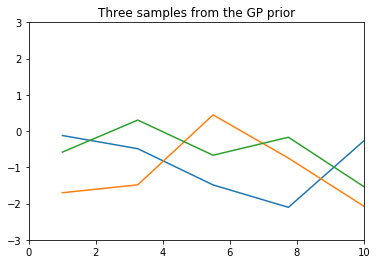

In [12]:
import numpy as np
import matplotlib.pyplot as pl

# Test data
n = 5
Xtest = np.linspace(1, 10, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    ret_ar = []
    sqdist = a.transpose()*b
    for a_ in a:
        tmp = []
        for b_ in b:
            S,I,R = sir_step(.9,.1,0,a_*b_)
            tmp.append(I[-1])
        ret_ar.append(tmp)
    return ret_ar

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
print (K_ss)
L = np.linalg.cholesky(K_ss + np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([0, 10, -3, 3])
pl.title('Three samples from the GP prior')
pl.show()

In [64]:
import GPy

m = GPy.models.GPRegression(np.arange(0,100).reshape((-1,1)), time_series.reshape((-1,1)))

    # set the lengthscale to be something sensible (defaults to 1)
m.kern.lengthscale = 10.

m.optimize('bfgs', max_iters=200)